In [1]:
from pprint import pprint
import os, sys

# import reframe test script:
sys.path.append('../reframe') # so that next line can find reframe itself ...
import reframe_imb

In [2]:
# find output files for this test:
def find_run_outputs(root='.', test=None, ext='.out'):
    """ Find test files within an output tree.
    
        Args:
            root: path to start searching from
            test: str, limit results to directories which contain this string (default: all)
            ext: str, limit results to files with this extension
        
        Returns a sequence of str paths.
    """
    
    # directory is soemthing like:
    # ../output/sausage-newslurm/compute/gnu8-openmpi3/IMB_MPI1Test/
    
    # TODO: use reframe/reframe/frontend/cli.py code to get the current system, something like
    # import reframe
    # import reframe.core.config as config
    # import reframe.core.runtime as runtime
    # import os

    # # assume default location!
    # print(reframe.INSTALL_PREFIX)
    # config_file = os.path.join(reframe.INSTALL_PREFIX, 'reframe/settings.py')
    # settings = config.load_settings_from_file(config_file)
    # runtime.init_runtime(settings.site_configuration, options.system,
    #                              non_default_craype=options.non_default_craype)
    
    results = []
    for (dirpath, dirnames, filenames) in os.walk(root):
        # in-place filter dirnames to avoid hidden directories:
        for idx, d in enumerate(dirnames):
            if d.startswith('.'):
                del dirnames[idx]
        for f in filenames:
            if os.path.splitext(f)[-1] == ext:
                path = os.path.join(dirpath, f)
                testdir = os.path.basename(os.path.dirname(path))
                if test is None or test in testdir:
                    results.append(path)
    return(results)
                
run_outputs = find_run_outputs('../output', 'IMB')
print(run_outputs)

['../output/alaska/compute-ib/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out', '../output/alaska/compute-ib/gnu-openmpi/IMB_Uniband/rfm_IMB_Uniband_job.out', '../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out', '../output/alaska/compute-roce/gnu-openmpi/IMB_Uniband/rfm_IMB_Uniband_job.out']


In [3]:
# load results using the same function that we use for reframe performance tests:
# TODO: add groupby= based off metadata?
results = []
for path in run_outputs:
    result = reframe_imb.read_imb_out(path)
    results.append(result)
    print('read', path)
    pprint(result['meta'])

read ../output/alaska/compute-ib/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out
{'benchmark': 'pingpong',
 'environ': 'gnu-openmpi',
 'filename': 'rfm_IMB_PingPong_job.out',
 'partition': 'compute-ib',
 'path': '../output/alaska/compute-ib/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out',
 'processes': 2,
 'sysname': 'alaska',
 'testname': 'IMB_PingPong'}
read ../output/alaska/compute-ib/gnu-openmpi/IMB_Uniband/rfm_IMB_Uniband_job.out
{'benchmark': 'uniband',
 'environ': 'gnu-openmpi',
 'filename': 'rfm_IMB_Uniband_job.out',
 'partition': 'compute-ib',
 'path': '../output/alaska/compute-ib/gnu-openmpi/IMB_Uniband/rfm_IMB_Uniband_job.out',
 'processes': 2,
 'sysname': 'alaska',
 'testname': 'IMB_Uniband'}
read ../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out
{'benchmark': 'pingpong',
 'environ': 'gnu-openmpi',
 'filename': 'rfm_IMB_PingPong_job.out',
 'partition': 'compute-roce',
 'path': '../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB

In [4]:
# Group results by *testname*

test_results = {} # key: test name

for result in results:
    testname = result['meta']['testname']
    cases = test_results.setdefault(testname, [])
    cases.append(result)

for test, cases in test_results.items():
    print(test, ':')
    for c in cases:
        print('  ', c['meta']['filename'])
        #pprint(c['meta'])

IMB_PingPong :
   rfm_IMB_PingPong_job.out
   rfm_IMB_PingPong_job.out
IMB_Uniband :
   rfm_IMB_Uniband_job.out
   rfm_IMB_Uniband_job.out


In [5]:
def diff_meta(results, ignore=['path']):
    """ Given a sequence of results dicts, returns
            
            common, [difference1, difference2, ...]
        
        where each of these are dicts based on the ['meta'] properties of each result dict
        ignoring given keys
        
        TODO: describe this properly
    """
    
    meta = [r['meta'].copy() for r in results]
    
    for key in ignore:
        for m in meta:
            m.pop(key, None)
    keyvals = [set(zip(m.keys(), m.values())) for m in meta]
    common = keyvals[0].intersection(*keyvals[1:])
    differences = [dict(b.difference(common)) for b in keyvals]
    return dict(common), differences
                   
# tests:                   
c, d = diff_meta(test_results['IMB_PingPong'])
print('common:')
pprint(c)
print('differences:')
pprint(d)


common:
{'benchmark': 'pingpong',
 'environ': 'gnu-openmpi',
 'filename': 'rfm_IMB_PingPong_job.out',
 'processes': 2,
 'sysname': 'alaska',
 'testname': 'IMB_PingPong'}
differences:
[{'partition': 'compute-ib'}, {'partition': 'compute-roce'}]


In [6]:
# read perflog info:
def read_perflog(path):
    perf = []
    with open(path) as f:
        for line in f:
            # TODO: read this from reframe-settings handlers_perflog/filelog?
            LOG_FIELDS = 'completion_time,reframe_version,check_system,check_partition,environ,testname,jobid,perf_data,perf_unit,perf_ref'.split(',')
            record = dict(zip(LOG_FIELDS,line.split('|')))
            perf_var, perf_value = record['perf_data'].split('=')
            record['perf_var'] = perf_value
            perf.append(record)
    return perf


def get_perflogs(root='../perflogs', system=None, partition=None, test=None):
    records = []
    for (dirpath, dirnames, filenames) in os.walk(root):
        for f in filenames:
            if os.path.splitext(f)[-1] != '.log':
                continue
            path = os.path.join(dirpath, f)
            meta = reframe_imb.parse_path_metadata(path)
            if system is None or meta['sysname'] == system:
                if partition is None or meta['partition'] == partition:
                    if test is None or meta['testname'] == test:
                        logrecords = read_perflog(path)
                        records.extend(logrecords)
    return records


# for record in get_perflogs():
#     print(record)
#     print(perf_log)

IMB_PingPong :
[{'completion_time': '2020-05-26T11:22:53+01:00', 'reframe_version': 'reframe 3.0-dev6 (rev: 3f0c45d4)', 'check_system': 'alaska', 'check_partition': 'compute-ib', 'environ': 'gnu-openmpi', 'testname': 'IMB_PingPong', 'jobid': 'jobid=358', 'perf_data': 'pingpong_max_bandwidth=11926.96', 'perf_unit': 'Mbytes/sec', 'perf_ref': 'ref=0 (l=None, u=None)\n', 'perf_var': '11926.96'}, {'completion_time': '2020-05-26T11:22:53+01:00', 'reframe_version': 'reframe 3.0-dev6 (rev: 3f0c45d4)', 'check_system': 'alaska', 'check_partition': 'compute-ib', 'environ': 'gnu-openmpi', 'testname': 'IMB_PingPong', 'jobid': 'jobid=358', 'perf_data': 'pingpong_min_latency=1.31', 'perf_unit': 't[usec]', 'perf_ref': 'ref=0 (l=None, u=None)\n', 'perf_var': '1.31'}, {'completion_time': '2020-05-26T11:23:41+01:00', 'reframe_version': 'reframe 3.0-dev6 (rev: 3f0c45d4)', 'check_system': 'alaska', 'check_partition': 'compute-ib', 'environ': 'gnu-openmpi', 'testname': 'IMB_PingPong', 'jobid': 'jobid=362', 

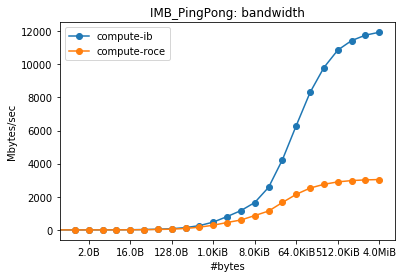

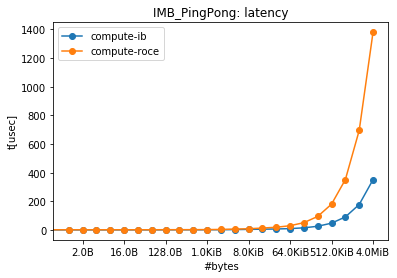

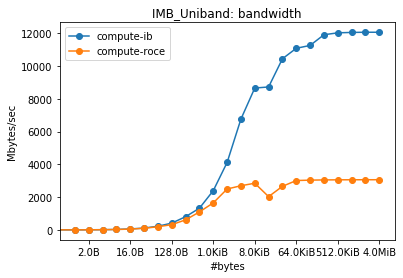

In [22]:
# Plotting:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker

# TODO: add latency for pingpong

def sizeof_fmt(num, suffix='B'):
    # from https://stackoverflow.com/a/1094933/916373
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


# TODO: can we derive this from the test metrics somehow??
PLOTS = [
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'t[usec]',
        'metric':'latency',
    },
    {
        'test':'IMB_Uniband',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },
    
    
]

for plot in PLOTS:
    cases = test_results[plot['test']]
    print(plot['test'], ':')
    common, differences = diff_meta(cases)
    plt.figure()
    #perf_records = get_perflogs(test=plot['test']) # TODO: should we have a meta: field for these too?
    print(perf_records)
    for ix, case in enumerate(cases):
        data = case['data']
        unique_meta = differences[ix]
        label = '-'.join(list(unique_meta.values()))
        plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=label)
        plt.grid()
        plt.title('%s: %s' % (plot['test'], plot['metric']))
        plt.legend()
        plt.grid()
        ax = plt.gca()
        ax.set_xscale('log', basex=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: sizeof_fmt(x)))
        plt.xlabel(plot['xaxis'])
        plt.ylabel(plot['yaxis'])
    
# #   latency:
# plt.figure()
# #perf_records = get_perflogs(test='IMB_PingPong')
# for ix, case in enumerate(cases):
#     data = case['data']
#     unique_meta = differences[ix]
#     label = '-'.join(list(unique_meta.values()))
#     plt.plot(data['#bytes'], data['t[usec]'], 'o-', label=label)

#     plt.grid()
#     plt.title('IMB_PingPong: latency')
#     plt.legend()
#     ax = plt.gca()
#     ax.set_xscale('log', basex=2)
#     ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: sizeof_fmt(x)))
#     plt.xlabel('#bytes')
#     plt.ylabel('t[usec]')
    


# for test, cases in test_results.items():
#     print(test, ':')
#     common, differences = diff_meta(cases)
#     plt.figure()
#     perf_records = get_perflogs(test=test)
#     for record in perf_records:
#         print(record)
#     for ix, case in enumerate(cases):
#         data = case['data']
#         unique_meta = differences[ix]
#         label = '-'.join(list(unique_meta.values()))
#         plt.plot(data['#bytes'], data['Mbytes/sec'], 'o-', label=label)
        
#         plt.grid()
#         plt.title(test)
#         plt.legend()
#         ax = plt.gca()
#         ax.set_xscale('log', basex=2)
#         ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: sizeof_fmt(x)))
#         plt.xlabel('#bytes')
#         plt.ylabel('Mbytes/sec')
#     print('====')
        
        